# Customised Named Entity Recognition (NER) model for job advertisements
## Dependency
**Note**: To run this notebook, the following packages should be installed
- spacy
- pandas


I have successfully tested the notebook in Python 3.7+, it should also work in other Python3.x environment

## Overview
This notebook demonstrates a possible solution to automated recognition and annotation of customised entities, such as skills, experience, qualification, responsibilities and other requirements, in a job advertisement. The NER model developed in this notebook was built and trained using the [spaCy](https://spacy.io/) library (v3.1), an open-source NLP python package.

To train the NER model, I filtered out a total of 373 job advertisements, which contains the keywords of *machine learning*, *data science/scientist*, *AI* and *artificial intelligence* in the job description, from the provided 50,000 json files of job advertisements. From these 373 job advertisements, I randomly selected 140 job advertisements(100/20 job advertisements used for training/validating NER model and the remaining 20 job advertisements used for evaluating the generalisation performance of the NER model ) and manually annotated 5 types of customised entities, i.e. **SKILLS**, **EXPERIENCE**, **QUALIFICATION**, **RESPONSIBILITIES** and **REQUIREMENTS**, in the selected job advertisements.

Explanation on the annotation criteria

| Entity | Description |
|--------| ----------- |
| SKILLS | Ability, knowledge, understanding required by the position |
| EXPERIENCE | xxx years experience required by the position |
| RESPONSIBILITIES | Duties/responsibilities required by the position |
| QUALIFICATION | Degree/Diploma/Certificates required by the position |
| REQUIREMENTS | Requirements other than skills/experience/qualifications/responsibilities needed by the position |

The following picture shows the screenshot of annotated texts for different entities

![picture](NER_Annotation.png "Screenshot of annotated texts for different entities")

The annotation tool used for NER is [Ubiai](https://ubiai.tools/). As this tool uses the same tokenization method as the spaCy, it can generate the annotation data for training a spaCy model without wrong span of labeled entities.

It is obvious that the model performance is significantly limited by the small number of training samples. Due to the time availability, I only annotated a small portion of the job advertisements for proof-of-the-concept of the proposed solution.



A quick look at the pipelines in this notebook

<ol>
    <li>Prepare training/validation/test data
        <ul>
            <li> Convert annotation data to JSON format
            <li> Distribution of labeled entities
        </ul>
    <li> Baseline model
         <ul>
             <li> Training baseline model
             <li> Evaluation of baseline model
        </ul>
    <li> Pre-trained model
        <ul>
             <li> Training pre-trained model
             <li> Evaluation of pre-trained model
        </ul>
</ol>

In [ ]:
!pip install -r requirements.txt

Download the required language model

In [ ]:
!python -m spacy download en_core_web_sm

In [2]:
import random
import json
import os
import spacy
from spacy.training.example import Example
import cupy
import numpy as np

Fix seed values to secure reproducible results

In [3]:
def seed_everything(seed):
    spacy.util.fix_random_seed(seed)
    cupy.random.seed(seed)
    np.random.seed(seed)

seed_everything(seed = 1)

## Prepare training/validation/test data

### Convert annotation data to JSON format

Convert the json files generated by Ubiai to the annotation format that can be processed by Spacy

In [4]:
def prepare_annotation_data(annotation_filename, ubiai_json_format=False):
    annotation_data = []
    
    if ubiai_json_format:
        with open(annotation_filename) as f:
            json_data = json.load(f)
        # convert json data from ubiai format to normal format
        for doc in json_data:
            text = doc["document"]
            ent = []
            doc_dict={}
            for anno in doc["annotation"]:
                annnotation = [anno["start"], anno["end"], anno["label"]]
                ent.append(annnotation)
            doc_dict["entities"] = ent
            annotation_data.append([text, doc_dict])

    else:
        # combine multiple lines of annotation data in a json file into a list
        with open(annotation_filename, "r") as f:
            lines = f.readlines()
            for line in lines:
                annotation = json.loads(line)["annotations"][0]
                annotation_data.append(annotation)
                
    
    return annotation_data


In [5]:
# load train/val data from multiple lines in a json file 
train_data = prepare_annotation_data("train_100.json", True)
val_data = prepare_annotation_data("val_20.json", True)

### Distribution of labeled entities in annotation data

In [6]:
# count the number of each labeled entities
def get_entity_distribution(input_json_data):
    """
    input_json_data: annotated data in json format
    Annotations of all labeled documentations are recorded in the following format
    annotation:[[doc_1, {"entities":[[start, end, label], [start, end, label], .... [start, end, label]]}],
                [doc_2, {"entities":[[start, end, label], [start, end, label], .... [start, end, label]]}],
                ...
                [doc_N, {"entities":[[start, end, label], [start, end, label], .... [start, end, label]]}]]
    
    """
    
    labels = {}
    # load all lines in an annotation file to a list 
    for text, annot in input_json_data:
        for start, end, entity in annot["entities"]:
            if entity not in labels:
                    labels[entity] = 1  
            else: 
                labels[entity] += 1

    return labels

In [7]:
# Count the number of each labeled entity in training set
train_labels = get_entity_distribution(train_data)
print(f"Label distribution in training set:{train_labels}")

Label distribution in training set:{'RESPONSIBILITIES': 461, 'QUALIFICATION': 174, 'EXPERIENCE': 240, 'SKILLS': 426, 'REQUIREMENTS': 145}


[Text(0, 0, 'RESPONSIBILITIES'),
 Text(1, 0, 'QUALIFICATION'),
 Text(2, 0, 'EXPERIENCE'),
 Text(3, 0, 'SKILLS'),
 Text(4, 0, 'REQUIREMENTS')]

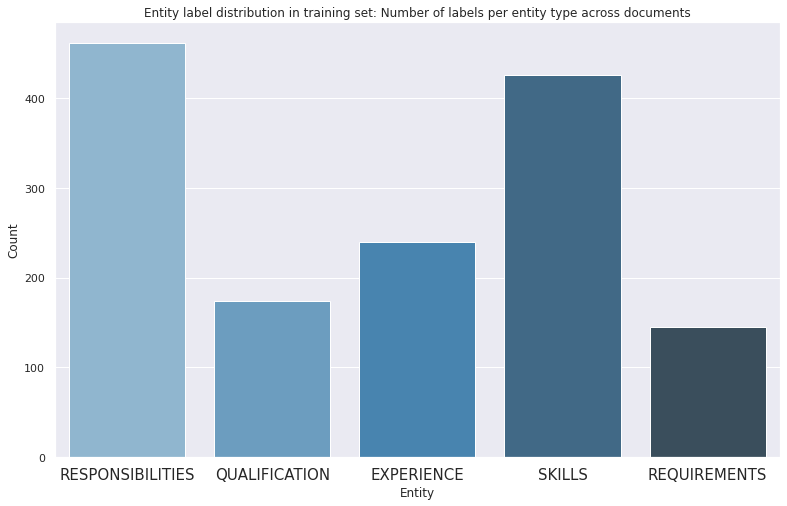

In [8]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

label_df = pd.DataFrame.from_dict(train_labels, orient='index', columns=["Count"])
label_df.reset_index(inplace=True)
label_df.rename(columns={'index':'Entity'}, inplace=True)

sns.set(rc={'figure.figsize':(13,8)})
Entitybar = sns.barplot(x="Entity", y="Count", data=label_df, palette="Blues_d")
plt.title('Entity label distribution in training set: Number of labels per entity type across documents')
Entitybar.set_xticklabels(Entitybar.get_xticklabels(), fontsize = 15)

In [9]:
# Count the number of each labeled entity in val set
val_labels = get_entity_distribution(val_data)
print(f"Label distribution in validation set:{val_labels}")

Label distribution in validation set:{'RESPONSIBILITIES': 150, 'REQUIREMENTS': 44, 'QUALIFICATION': 38, 'EXPERIENCE': 85, 'SKILLS': 113}


[Text(0, 0, 'RESPONSIBILITIES'),
 Text(1, 0, 'REQUIREMENTS'),
 Text(2, 0, 'QUALIFICATION'),
 Text(3, 0, 'EXPERIENCE'),
 Text(4, 0, 'SKILLS')]

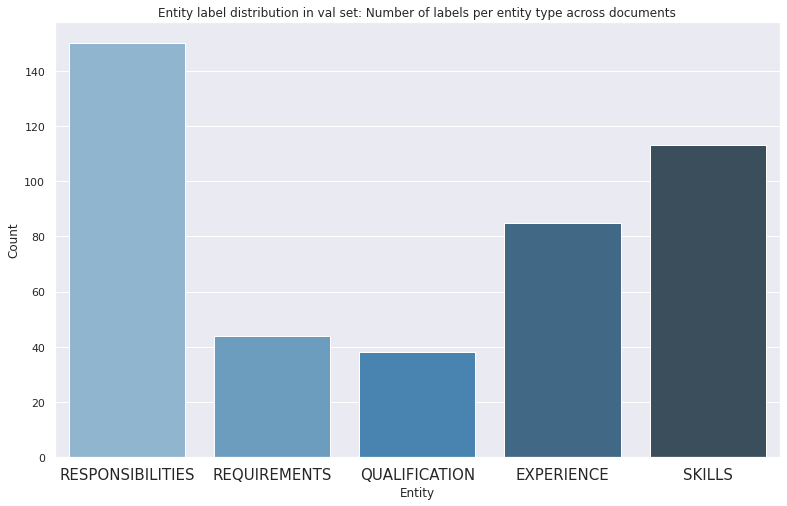

In [10]:
label_df = pd.DataFrame.from_dict(val_labels, orient='index', columns=["Count"])
label_df.reset_index(inplace=True)
label_df.rename(columns={'index':'Entity'}, inplace=True)

sns.set(rc={'figure.figsize':(13,8)})
Entitybar = sns.barplot(x="Entity", y="Count", data=label_df, palette="Blues_d")
plt.title('Entity label distribution in val set: Number of labels per entity type across documents')
Entitybar.set_xticklabels(Entitybar.get_xticklabels(), fontsize = 15)

We can see that the entity "RESPONSIBILITIES" has the most number of annotations, and the entity "REQUIREMENTS" and "QUALIFICATION" has the least number of annotations in training and validation set, respectively. The annotations are almost equally distributed across all 5 entities in training data.

## spaCy pipeline of English language model
spaCy is a powerful NLP package designed for production environment. In spaCy library, a typical processing pipeline for English language model comprises components of **tokenizer**, **tagger**, **parser**, **lemmatizer**, **ner**, **textcat** etc., as shown below

![picture](spacy_pipeline.png "spaCy pipeline for English language model")

<center> 

[**Processing pipeline of English language model in spaCy library**](https://spacy.io/usage/processing-pipelines) 

</center>

## Baseline model

We create a blank English language model, only add **"ner"** component to the pipeline and train this blank language model on our annotated data for recognition of customised entities. This NER model is our baseline model which will be later compared with the pre-trained model in spaCy for automatic annotation of customised entities in job advertisements

### Training baseline model
In the training process, we evaluate the model on validation set at the end each epoch (the evaluation frequency can be adjusted by the parmeter ```eval_freq``` ), and save the model that has the minimum loss on validation set. This best performed model is the final model for deployment. Note that the hyper-parameters of DNN model used in spaCy library be also tuned on validation set.

In [11]:
def train_baseline_model(TRAIN_DATA, VAL_DATA, epochs, model_path, eval_freq=5, batch_size=128):
    
    # create a blank english model
    nlp = spacy.blank("en")

    #add ner component to pipeline
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe("ner", last=True)

    # load labels to NER
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    print(f'loaded {len(ner.labels)} labels: {ner.labels}')

    #obtain the other components in the pipeline
    include_components = ["ner"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in include_components]

    # disable other components, only train ner model
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()
        # optimizer = nlp.create_optimizer()
        
        train_loss, val_loss, val_f1, val_recall, val_precision = [], [], [], [], []
        val_min_loss = 1000
        best_model_dir = os.path.join(model_path, "best_model")
        os.makedirs(best_model_dir, exist_ok=True)
        
        for ep in range(epochs):
            print ("Starting epoch " + str(ep+1))
            random.seed(1)
            random.shuffle(TRAIN_DATA)
            train_losses = {}
            val_losses = {}
            
            for batch in spacy.util.minibatch(TRAIN_DATA, size=batch_size):
                for text, annotations in batch:
                    # create Example
                    doc = nlp.make_doc(text)                    
                    example = Example.from_dict(doc, annotations)

                    # Update the model
                    nlp.update([example], losses=train_losses, sgd=optimizer, drop=0.2)
            
            loss = train_losses["ner"]
            train_loss.append(loss)
            print(f"training loss:{loss}")
            
            # evaluate on val data every xxx epochs
            if (ep+1) % eval_freq == 0:
                val_exams = []
                for batch in spacy.util.minibatch(VAL_DATA, size=batch_size):
                    for text, annotations in batch:
                        doc = nlp.make_doc(text)
                        example = Example.from_dict(doc, annotations)
                        nlp.update([example], losses=val_losses, sgd=None, drop=0)
                        
                        val_exams.append(Example.from_dict(doc, annotations))

                val_scores = nlp.evaluate(val_exams)
                # keep the model that performance best on val set
                if val_losses["ner"] < val_min_loss:
                    val_min_loss = val_losses["ner"]
                    nlp.to_disk(best_model_dir)
                    best_performamce_epoch = ep+1
                    checkpoint_f1 = val_scores["ents_f"]
                
                val_f1.append(val_scores["ents_f"])
                val_recall.append(val_scores["ents_r"])
                val_precision.append(val_scores["ents_p"])
                val_loss.append(val_losses["ner"])
                loss = val_losses["ner"]
                f1 = val_scores["ents_f"]
                recall = val_scores["ents_r"]
                precision = val_scores["ents_p"]
                print(f"evaluate on val set, ner_loss: {loss}, f1 score: {f1}, precision: {precision}, recall: {recall}")
                
        print(f'saved model with best performance at epoch {best_performamce_epoch}, val loss:{val_min_loss}, val f1 score:{checkpoint_f1}')
        
    return nlp, train_loss, val_loss, val_f1, val_recall, val_precision

In [13]:
# train baseline model on GPU
spacy.prefer_gpu()
epochs = 50
model = "baseline"
model_path = "./output/baseline"
baseline_nlp, train_loss, val_loss, val_f1, val_recall, val_precision = train_baseline_model(train_data, val_data, epochs, model_path, eval_freq=1)

loaded 5 labels: ('EXPERIENCE', 'QUALIFICATION', 'REQUIREMENTS', 'RESPONSIBILITIES', 'SKILLS')
Starting epoch 1
training loss:13351.965593835703
evaluate on val set, ner_loss: 3571.614047743614, f1 score: 0.0, precision: 0.0, recall: 0.0
Starting epoch 2
training loss:8308.299131152891
evaluate on val set, ner_loss: 1654.3423548683725, f1 score: 0.21467391304347827, precision: 0.2581699346405229, recall: 0.18372093023255814
Starting epoch 3
training loss:3770.8688482754487
evaluate on val set, ner_loss: 817.6894556281495, f1 score: 0.3950617283950617, precision: 0.42105263157894735, recall: 0.37209302325581395
Starting epoch 4
training loss:3026.0544787982576
evaluate on val set, ner_loss: 678.4439576625753, f1 score: 0.42873696407879497, precision: 0.42725173210161665, recall: 0.43023255813953487
Starting epoch 5
training loss:3232.413269715211
evaluate on val set, ner_loss: 668.4742131508747, f1 score: 0.48045977011494245, precision: 0.475, recall: 0.48604651162790696
Starting epoch 

Draw train/val loss vs. epoch curve

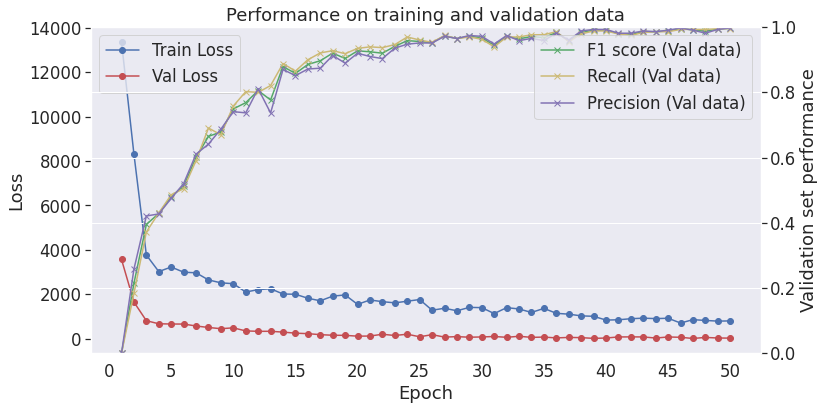

In [22]:
# training/valid loss vs. epoch curve 
import seaborn as sns
import matplotlib.pyplot as plt

def plot_performance_curve(train_loss, val_loss, val_f1, val_recall, val_precision, epochs, model_name):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the loss curve and performance values.
    epoch = list(range(1, epochs + 1))
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(epoch, train_loss, 'b-o', label="Train Loss")
    ax1.plot(epoch, val_loss, 'r-o', label="Val Loss")
    ax1.set_ylabel('Loss')
    ax1.set_xlabel("Epoch")
    # ax1.set_xticks(np.arange(0, len(x)+1, 25))
    ax1.legend(loc='upper left')
    ax1.grid()

    ax2 = ax1.twinx()
    ax2.plot(epoch, val_f1, 'g-x', label="F1 score (Val data)")
    ax2.plot(epoch, val_recall, 'y-x', label="Recall (Val data)")
    ax2.plot(epoch, val_precision, 'm-x', label="Precision (Val data)")
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation set performance')
    ax2.legend(loc='upper right')
    ax2.set_ylim(0, 1)

    plt.xticks(list(range(0, epochs + 1, 5)))
    plt.title("Performance on training and validation data")
    plt.savefig(f"{model_name}_train_curve.png")
    plt.show()

plot_performance_curve(train_loss, val_loss, val_f1, val_recall, val_precision, epochs, model)

In [23]:
# save trained model
baseline_nlp.to_disk(model_path)

### Evaluation of baseline model

First load baseline model

In [24]:
"""
==========================================================================
Model evaluation
==========================================================================
"""
# load model
trained_nlp = spacy.load(os.path.join(model_path, "best_model"))
print('NER model loaded')

NER model loaded


Prepare test data and show the entity distribution on test data

In [25]:
print ("load test data")

# load test data
test_data = prepare_annotation_data("test_20.json", True)
# count number of labeled entities in test data
test_labels = get_entity_distribution(test_data)
print(f"test label distribution: {test_labels}")

load test data
test label distribution: {'RESPONSIBILITIES': 97, 'SKILLS': 50, 'REQUIREMENTS': 46, 'EXPERIENCE': 36, 'QUALIFICATION': 34}


[Text(0, 0, 'RESPONSIBILITIES'),
 Text(1, 0, 'SKILLS'),
 Text(2, 0, 'REQUIREMENTS'),
 Text(3, 0, 'EXPERIENCE'),
 Text(4, 0, 'QUALIFICATION')]

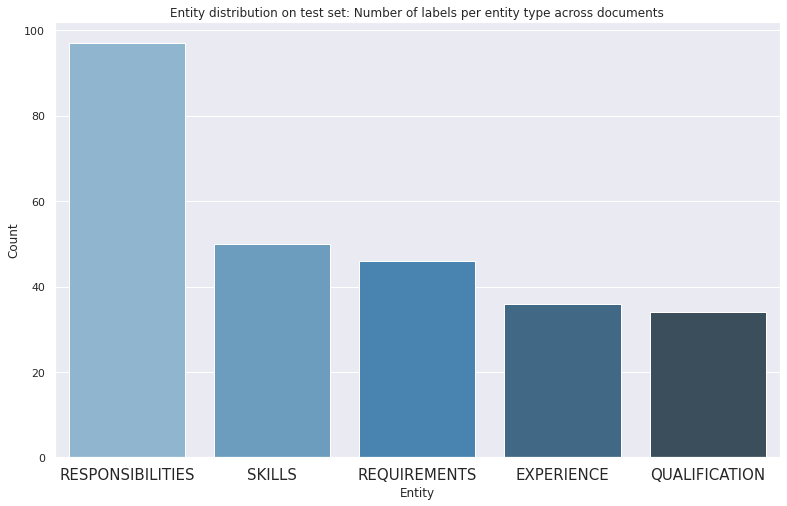

In [26]:
label_df = pd.DataFrame.from_dict(test_labels, orient='index', columns=["Count"])
label_df.reset_index(inplace=True)
label_df.rename(columns={'index':'Entity'}, inplace=True)

sns.set(rc={'figure.figsize':(13,8)})
Entitybar = sns.barplot(x="Entity", y="Count", data=label_df, palette="Blues_d")
plt.title('Entity distribution on test set: Number of labels per entity type across documents')
Entitybar.set_xticklabels(Entitybar.get_xticklabels(), fontsize = 15)

Evaluate baseline model on test data

In [27]:
print ("evaluate trained NER model on test set")

test_exams = []
for text, annotations in test_data:
    doc = trained_nlp.make_doc(text)
    test_exams.append(Example.from_dict(doc, annotations))

scores = trained_nlp.evaluate(test_exams)

evaluate trained NER model on test set


Show the evaluation result on test data

overall metics: f1 score 0.6328125, precision 0.6506024096385542, recall 0.6159695817490495
metrics of each entity
SKILLS: f1 score 0.6785714285714285, precision 0.6129032258064516, recall 0.76
RESPONSIBILITIES: f1 score 0.648936170212766, precision 0.6703296703296703, recall 0.6288659793814433
REQUIREMENTS: f1 score 0.54320987654321, precision 0.6285714285714286, recall 0.4782608695652174
QUALIFICATION: f1 score 0.6451612903225806, precision 0.7142857142857143, recall 0.5882352941176471
EXPERIENCE: f1 score 0.6086956521739131, precision 0.6363636363636364, recall 0.5833333333333334


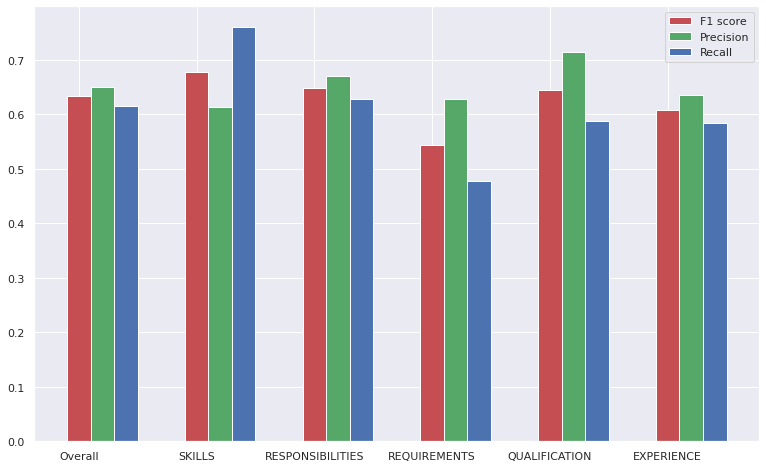

In [28]:
def get_eval_result(scores, model_name):
    f1, pre, rec = [], [], []
    
    # metrics over all entities
    all_ent_f1 = scores["ents_f"]
    all_ent_pre = scores["ents_p"]
    all_ent_rec = scores["ents_r"]
    f1.append(all_ent_f1)
    pre.append(all_ent_pre)
    rec.append(all_ent_rec)
    
    # entity-wise metrics
    skills_f1 = scores["ents_per_type"]["SKILLS"]["f"]
    skills_pre = scores["ents_per_type"]["SKILLS"]["p"]
    skills_rec = scores["ents_per_type"]["SKILLS"]["r"]
    f1.append(skills_f1)
    pre.append(skills_pre)
    rec.append(skills_rec)

    res_f1 = scores["ents_per_type"]["RESPONSIBILITIES"]["f"]
    res_pre = scores["ents_per_type"]["RESPONSIBILITIES"]["p"]
    res_rec = scores["ents_per_type"]["RESPONSIBILITIES"]["r"]
    f1.append(res_f1)
    pre.append(res_pre)
    rec.append(res_rec)

    req_f1 = scores["ents_per_type"]["REQUIREMENTS"]["f"]
    req_pre = scores["ents_per_type"]["REQUIREMENTS"]["p"]
    req_rec = scores["ents_per_type"]["REQUIREMENTS"]["r"]
    f1.append(req_f1)
    pre.append(req_pre)
    rec.append(req_rec)
    
    qua_f1 = scores["ents_per_type"]["QUALIFICATION"]["f"]
    qua_pre = scores["ents_per_type"]["QUALIFICATION"]["p"]
    qua_rec = scores["ents_per_type"]["QUALIFICATION"]["r"]
    f1.append(qua_f1)
    pre.append(qua_pre)
    rec.append(qua_rec)
    
    exp_f1 = scores["ents_per_type"]["EXPERIENCE"]["f"]
    exp_pre = scores["ents_per_type"]["EXPERIENCE"]["p"]
    exp_rec = scores["ents_per_type"]["EXPERIENCE"]["r"]
    f1.append(exp_f1)
    pre.append(exp_pre)
    rec.append(exp_rec)
    
    print(f"overall metics: f1 score {all_ent_f1}, precision {all_ent_pre}, recall {all_ent_rec}")
    print(f"metrics of each entity")
    print(f"SKILLS: f1 score {skills_f1}, precision {skills_pre}, recall {skills_rec}")
    print(f"RESPONSIBILITIES: f1 score {res_f1}, precision {res_pre}, recall {res_rec}")
    print(f"REQUIREMENTS: f1 score {req_f1}, precision {req_pre}, recall {req_rec}")
    print(f"QUALIFICATION: f1 score {qua_f1}, precision {qua_pre}, recall {qua_rec}")
    print(f"EXPERIENCE: f1 score {exp_f1}, precision {exp_pre}, recall {exp_rec}")


    ent_list = ["Overall", "SKILLS", "RESPONSIBILITIES", "REQUIREMENTS", "QUALIFICATION", "EXPERIENCE"]
    x = list(range(len(ent_list)))
    total_width, n = 0.8, 4
    width = total_width / n
    plt.bar(x, f1, width=width, label='F1 score', tick_label=ent_list, fc='r')
    for i in range(len(x)):
        x[i] = x[i] + width
    plt.bar(x, pre, width=width, label='Precision', fc='g')
    for i in range(len(x)):
        x[i] = x[i] + width
    plt.bar(x, rec, width=width, label='Recall', fc='b')
    plt.legend()
    plt.savefig(f"{model_name}_evaluation_metric.png")
    plt.show()

get_eval_result(scores, model)

Inference of baseline model on specific examples

In [29]:
def ner_infer(filename, nlp):
    text = str()
    with open(os.path.join('/fred/oz193/ads_txt', filename), 'r') as f:
        contents = f.readlines()
        for content in contents:
            text = text + content

    doc = nlp(text)
    # extract all entities and its labels in the text
    if len(doc.ents) == 0:
        print ("No entities found.")
    else:
        print(filename.split('.')[0])
        spacy.displacy.render(doc, style="ent", jupyter=True)

Inference advertisements in test set 

In [30]:
filenames = ['ad_38998815.txt', 'ad_38997579.txt', 'ad_38997179.txt']
for filename in filenames:
    ner_infer(filename, trained_nlp)

ad_38998815


ad_38997579


ad_38997179


## Pre-trained model

In this solution, we load the pre-trained English language model (*en_core_web_sm*), use its  **tokenizer** component to encode an input text to its vector representation which is fed into a blank language model to train a NER model. We hope to leverage the power of pre-trained word embeddings model to improve the accuracy of the baseline NER model.

### Train pre-trained model

In [32]:
def Finetune_pretrain_model(TRAIN_DATA, VAL_DATA, epochs, model_path, eval_freq=10, batch_size=128):
    
    # load a pre-trained english model
    source_nlp = spacy.load("en_core_web_sm")
    # create a blank new model
    nlp = spacy.blank("en")

    # add tokenizer to the pipeline of new model
    if "tok2vec" not in nlp.pipe_names:
        tok2vec = nlp.create_pipe("tok2vec")
        nlp.add_pipe("tok2vec", last=False, source=source_nlp)

    #add ner component to pipeline
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe("ner", last=True, source=source_nlp)

    # load labels to NER
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    print(f'loaded {len(ner.labels)} labels: {ner.labels}')

    #obtain the other components in the pipeline
    include_components = ["tok2vec", "ner"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in include_components]

    # disable other components, only train ner model
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.create_optimizer()
        
        train_loss, val_loss, val_f1, val_recall, val_precision = [], [], [], [], []
        val_min_loss = 1000
        best_model_dir = os.path.join(model_path, "best_model")
        os.makedirs(best_model_dir, exist_ok=True)
        
        for ep in range(epochs):
            print ("Starting epoch " + str(ep+1))
            random.seed(1)
            random.shuffle(TRAIN_DATA)        
            train_losses = {}
            val_losses = {}
            
            for batch in spacy.util.minibatch(TRAIN_DATA, size=batch_size):
                for text, annotations in batch:
                    # create Example
                    doc = nlp.make_doc(text)                    
                    example = Example.from_dict(doc, annotations)

                    # Update the model
                    nlp.update([example], losses=train_losses, sgd=optimizer, drop=0.2)
            
            loss = train_losses["ner"]
            train_loss.append(loss)
            print(f"training loss:{loss}")
            
            # evaluate on val data every xxx epochs
            if (ep+1) % eval_freq == 0:
                val_exams = []
                for batch in spacy.util.minibatch(VAL_DATA, size=batch_size):
                    for text, annotations in batch:
                        doc = nlp.make_doc(text)
                        example = Example.from_dict(doc, annotations)
                        nlp.update([example], losses=val_losses, sgd=None, drop=0)
                        
                        val_exams.append(Example.from_dict(doc, annotations))

                val_scores = nlp.evaluate(val_exams)
                # keep the model that performance best on val set
                if val_losses["ner"] < val_min_loss:
                    val_min_loss = val_losses["ner"]
                    nlp.to_disk(best_model_dir)
                    best_performamce_epoch = ep+1
                    checkpoint_f1 = val_scores["ents_f"]
                
                val_f1.append(val_scores["ents_f"])
                val_recall.append(val_scores["ents_r"])
                val_precision.append(val_scores["ents_p"])
                val_loss.append(val_losses["ner"])
                loss = val_losses["ner"]
                f1 = val_scores["ents_f"]
                recall = val_scores["ents_r"]
                precision = val_scores["ents_p"]
                print(f"evaluate on val set, ner_loss: {loss}, f1 score: {f1}, precision: {precision}, recall: {recall}")
                
        print(f'saved model with best performance at epoch {best_performamce_epoch}, val loss:{val_min_loss}, val f1 score:{checkpoint_f1}')
        
    return nlp, train_loss, val_loss, val_f1, val_recall, val_precision

In [33]:
model = "vector_based"
model_path = "./output/vector_based"
word2vec_nlp, train_loss, val_loss, val_f1, val_recall, val_precision = Finetune_pretrain_model(train_data, val_data, epochs, model_path, eval_freq=1)

loaded 5 labels: ('EXPERIENCE', 'QUALIFICATION', 'REQUIREMENTS', 'RESPONSIBILITIES', 'SKILLS')
Starting epoch 1
training loss:12521.899244974124
evaluate on val set, ner_loss: 3260.816224579249, f1 score: 0.0, precision: 0.0, recall: 0.0
Starting epoch 2
training loss:8413.643335172823
evaluate on val set, ner_loss: 1766.095374134773, f1 score: 0.2140672782874618, precision: 0.3125, recall: 0.16279069767441862
Starting epoch 3
training loss:3686.7121832384482
evaluate on val set, ner_loss: 679.7770446519685, f1 score: 0.4322916666666667, precision: 0.4911242603550296, recall: 0.386046511627907
Starting epoch 4
training loss:2751.007458663328
evaluate on val set, ner_loss: 626.2372463753757, f1 score: 0.5465538089480048, precision: 0.5692695214105793, recall: 0.5255813953488372
Starting epoch 5
training loss:2558.2489243202417
evaluate on val set, ner_loss: 493.8018759882694, f1 score: 0.5976190476190475, precision: 0.6121951219512195, recall: 0.5837209302325581
Starting epoch 6
trainin

Draw train/val loss vs. epoch curve

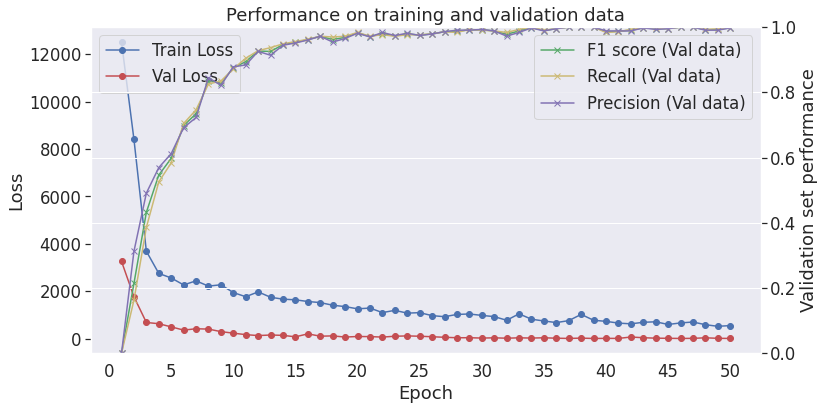

In [34]:
# training loss vs. epoch curve 
plot_performance_curve(train_loss, val_loss, val_f1, val_recall, val_precision, epochs, model)

In [35]:
# save trained model
word2vec_nlp.to_disk(model_path)

### Evaluation of pre-trained model

Load pre-trained language model

In [36]:
"""
==========================================================================
Model evaluation
==========================================================================
"""
# load model
trained_nlp = spacy.load(os.path.join(model_path, "best_model"))
print('NER model loaded')

NER model loaded


Evaluate pre-trained language model on test data

evaluate fine-tuned NER model on test set
overall metics: f1 score 0.6666666666666666, precision 0.7063829787234043, recall 0.6311787072243346
metrics of each entity
SKILLS: f1 score 0.7450980392156863, precision 0.7307692307692307, recall 0.76
RESPONSIBILITIES: f1 score 0.6594594594594594, precision 0.6931818181818182, recall 0.6288659793814433
REQUIREMENTS: f1 score 0.5853658536585366, precision 0.6666666666666666, recall 0.5217391304347826
QUALIFICATION: f1 score 0.6666666666666667, precision 0.7241379310344828, recall 0.6176470588235294
EXPERIENCE: f1 score 0.6666666666666666, precision 0.7333333333333333, recall 0.6111111111111112


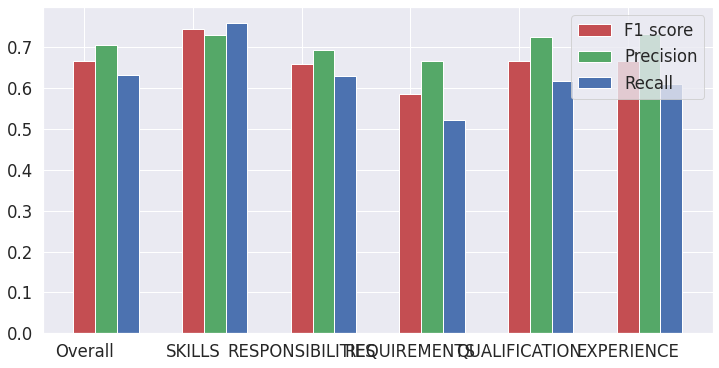

In [37]:
print ("evaluate fine-tuned NER model on test set")

test_exams = []
for text, annotations in test_data:
    doc = trained_nlp.make_doc(text)
    test_exams.append(Example.from_dict(doc, annotations))

scores = trained_nlp.evaluate(test_exams)

get_eval_result(scores, model)

Inference of pre-trained model on specific examples

In [38]:
filenames = ['ad_38998815.txt', 'ad_38997579.txt', 'ad_38997179.txt']
for filename in filenames:
    ner_infer(filename, trained_nlp)

ad_38998815


ad_38997579


ad_38997179
